In [1]:
import re
import json
import matplotlib.pyplot as plt
import numpy as np

### preprocessing

In [2]:
LEN_LISTS = [3,5,10]
MAX_DIGITS = 5

In [3]:
sorted_list_responses = []
rejected_responses = []

with open('gemini_response/list_sort_response.txt','r') as f:
    for line in f:
        # some line start with '-', we only need to extract between [ ]
        start = line.find('[')
        end = line.find(']')
        lst = line[start:end+1]

        # convert string to list
        lst = json.loads(lst)

        # check if len of lst is in LEN_LISTS
        if len(lst) in LEN_LISTS:
            sorted_list_responses.append(lst)
        else:
            rejected_responses.append(lst)
    
print('Number of valid responses:',len(sorted_list_responses))
print('Number of rejected responses:',len(rejected_responses))

print('rejected responses:')
for i in rejected_responses:
    print(i)

Number of valid responses: 2884
Number of rejected responses: 112
rejected responses:
[39874, 4073, 53004, 59270, 72869, 98052]
[1, 2, 3, 3, 5, 8, 9]
[0, 1, 3, 3, 4, 4, 4, 5, 9]
[0, 0, 2, 2, 4, 4, 7, 8, 8]
[3, 4, 4, 6, 6, 7, 7, 9, 9]
[0, 1, 3, 3, 3, 4, 4, 4, 9]
[0, 1, 1, 2, 2, 2, 4, 6, 8]
[1, 4, 4, 4, 4, 6, 7, 9, 9]
[1, 1, 1, 2, 4, 6, 7, 7, 8]
[24, 28, 29, 32, 77, 79, 81, 86, 96]
[12, 19, 32, 40, 47, 54, 85, 87, 93]
[8, 10, 11, 11, 12, 55, 60, 94, 95]
[15, 16, 42, 52, 71, 71, 71, 75, 85]
[13, 13, 19, 27, 28, 44, 61, 64, 73]
[0, 3, 10, 20, 23, 23, 34, 39, 43, 44, 89, 97]
[6, 10, 20, 27, 39, 43, 47, 48, 53, 58, 67, 95]
[9, 10, 29, 45, 48, 50, 64, 68, 71, 85, 90]
[2, 5, 9, 40, 54, 55, 58, 73, 94]
[2, 9, 14, 21, 37, 41, 51, 51, 53, 81, 90]
[11, 13, 31, 46, 55, 58, 75, 79, 88]
[9, 11, 19, 22, 63, 77, 80, 83, 97, 97, 98]
[29, 30, 36, 56, 78, 86, 92, 95, 96]
[75, 128, 324, 419, 588, 657, 787, 843, 995]
[286, 295, 395, 461, 516, 563, 566, 782, 845]
[17, 41, 46, 140, 306, 341, 39, 485, 512, 531

In [4]:
# check how many test examples were there
with open('../../data/lists.json','r') as file:
    input_data = json.load(file)
total_examples = 0
for type in input_data:
    total_examples += len(input_data[type])

print(f'total_input_examples: {total_examples}')
print('total_valid_responses:',len(sorted_list_responses))

total_input_examples: 3000
total_valid_responses: 2884


out of 3000 input test examples, only 2884 have a valid output. i.e, they have same number of list elements as were given in input [3,5,10]

### evaluation

In [5]:
def num_digits(num):
    return len(str(num).replace('-',''))

def max_num_digit(lst):
    return max([num_digits(num) for num in lst])

def is_sorted(lst):
    return all(lst[i]<=lst[i+1] for i in range(len(lst)-1))

In [6]:
# functions required for soft evaluation
def lenght_longest_nondecreasing_subsequence(lst):
    n = len(lst)
    dp = [1]*n
    for i in range(1,n):
        for j in range(i):
            if lst[i] >= lst[j]:
                dp[i] = max(dp[i],dp[j]+1)
    return max(dp)

def soft_sorted(lst):
    soft_score = lenght_longest_nondecreasing_subsequence(lst)/len(lst)
    return soft_score

In [7]:
total = np.zeros((2,3,MAX_DIGITS))
hard_correct = np.zeros((2,3,MAX_DIGITS))
soft_correct = np.zeros((2,3,MAX_DIGITS))

len_mapping = {3:0,5:1,10:2}

for list in sorted_list_responses:

    # get sign
    sign = 1 if any(num<0 for num in list) else 0  # 0 for +, 1 for -

    # get the length of the list
    len_list = len_mapping[len(list)]

    # get max number of digits of an element in the list
    num_digit = max_num_digit(list)

    # update count
    total[sign,len_list,num_digit-1] += 1
    hard_correct[sign,len_list,num_digit-1] += is_sorted(list)
    soft_correct[sign,len_list,num_digit-1] += soft_sorted(list)

hard_accuracy = hard_correct*100/total
soft_accuracy = soft_correct*100/total

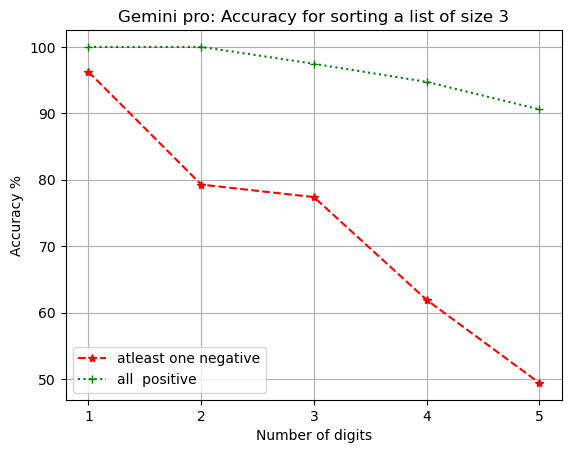

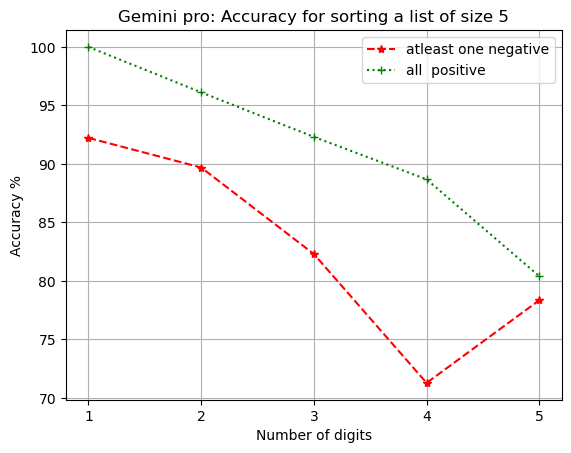

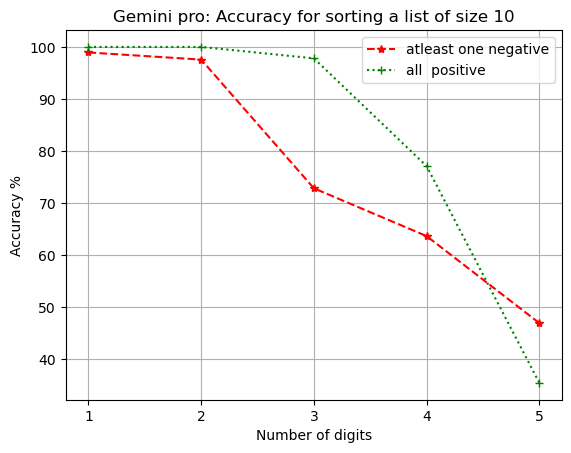

In [8]:
# 0 th index = sign , 0 for +, 1 for -
# 1st index = len of list, 0 for 3, 1 for 5, 2 for 10
# 2nd index = num of digits - 1

# for a list of length 3,
plt.plot(range(1,MAX_DIGITS+1),hard_accuracy[1,0,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),hard_accuracy[0,0,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Accuracy for sorting a list of size 3')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/sorting_accuracy_list_length_3.png')
plt.show()


# for a list of length 5,
plt.plot(range(1,MAX_DIGITS+1),hard_accuracy[1,1,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),hard_accuracy[0,1,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Accuracy for sorting a list of size 5')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/sorting_accuracy_list_length_5.png')
plt.show()

# for a list of length 10,
plt.plot(range(1,MAX_DIGITS+1),hard_accuracy[1,2,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),hard_accuracy[0,2,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Accuracy for sorting a list of size 10')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/sorting_accuracy_list_length_10.png')
plt.show()


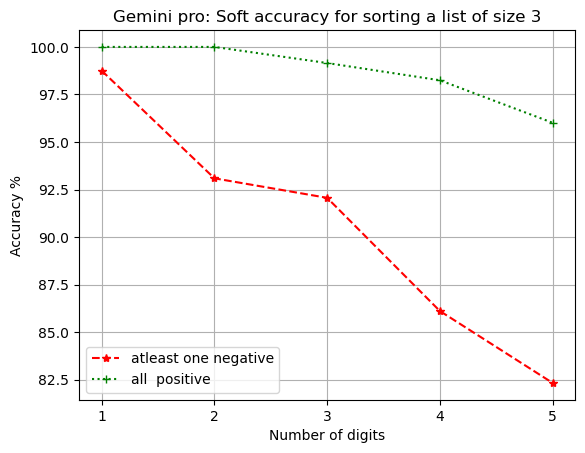

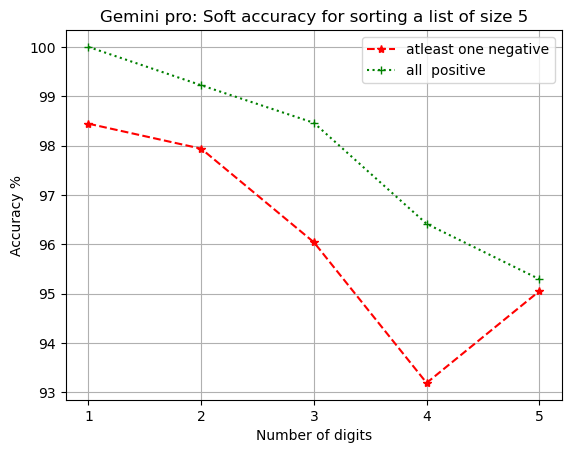

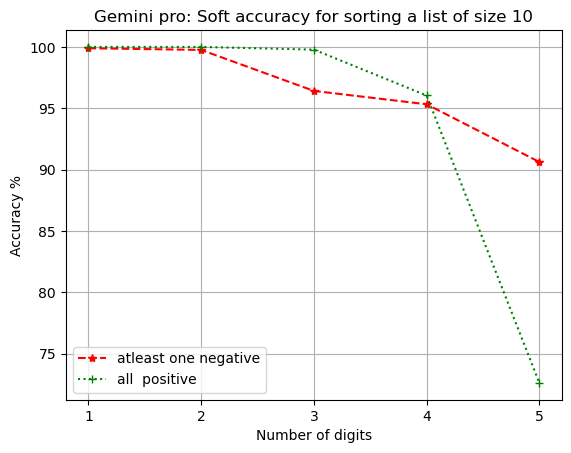

In [9]:
# 0 th index = sign , 0 for +, 1 for -
# 1st index = len of list, 0 for 3, 1 for 5, 2 for 10
# 2nd index = num of digits - 1

# for a list of length 3,
plt.plot(range(1,MAX_DIGITS+1),soft_accuracy[1,0,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),soft_accuracy[0,0,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Soft accuracy for sorting a list of size 3')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/sorting_soft_accuracy_list_length_3.png')
plt.show()


# for a list of length 5,
plt.plot(range(1,MAX_DIGITS+1),soft_accuracy[1,1,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),soft_accuracy[0,1,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Soft accuracy for sorting a list of size 5')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/sorting_soft_accuracy_list_length_5.png')
plt.show()

# for a list of length 10,
plt.plot(range(1,MAX_DIGITS+1),soft_accuracy[1,2,:],marker='*',linestyle='--',color='red',label='atleast one negative')
plt.plot(range(1,MAX_DIGITS+1),soft_accuracy[0,2,:],marker='+',linestyle=':',color='green',label='all  positive')
plt.xticks(range(1,MAX_DIGITS+1))
plt.xlabel('Number of digits')
plt.ylabel('Accuracy %')
plt.title('Gemini pro: Soft accuracy for sorting a list of size 10')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/sorting_soft_accuracy_list_length_10.png')
plt.show()
